### Nome dos integrantes: Ana Gabriela Gomes de Almeida Ferreira e Lucas Cunha de Souza
### Disciplina: Inteligência Artificial
### Professor: Sérgio Nery Simões

# Solução de Problemas de Otimização

- Este documento visa centralizar as soluções implementadas e comparar o desempenho por cada um deles.

- [HC-R] – Hill-Climbing with Restart.
- [SA] – Simulated Annealing.
- [GA] – Genetic Algorithm.

Antes de partirmos para a implementação, devemos importar as bibliotecas utilizadas para as funções auxiliares.

In [3]:
import random
import math
import numpy as np

from matplotlib import pyplot as plt
from IPython.display import clear_output

Após importarmos as bibliotecas, vamos começar a apresentar as funções auxiliares utilizadas no código para seguirmos com a resolução do problema das 8 rainhas.

In [30]:
# Cria uma solucao inicial com as rainhas em um ordem aleatoria
def solucao_aleatoria():
    return random.sample(range(1,9), 8)

In [5]:
# Função que recebe um Vetor-Tabuleiro e retorna o 
# número de pares de rainhas se atacando mutuamente nas linhas.
def __conta_ataques_linhas(VT):

    ataques = 0
    N = len(VT)
    for col1 in range(N):
        lin1 = VT[col1]
        for col2 in range(col1+1, N):
            lin2 = VT[col2]
            if lin1==lin2:
                ataques +=1

    return ataques

In [6]:
# Função que recebe um Vetor-Tabuleiro e retorna o número de pares 
# de rainhas se atacando mutuamente nas diagonais.
def __conta_ataques_diagonais(VT):
    
    ataques = 0
    N = len(VT)

    for col1 in range(N):
        lin1 = VT[col1]
        for col2 in range(col1+1, N):
            lin2 = VT[col2]

            # diferenças entre as linhas e colunas
            d1 = lin1-col1
            d2 = lin2-col2

            # somas das linhas e colunas
            s1 = lin1+col1
            s2 = lin2+col2

            # condições para ataques nas diagonais
            if d1==d2 or s1==s2:
                ataques +=1

    return ataques

In [7]:
# Função que recebe um Vetor-Tabuleiro e retorna o número de 
# pares de rainhas se atacando mutuamente nas linhas e diagonais.

# função-objetivo o número de pares de rainhas se atacando
def conta_ataques(VT):
    ataques  = __conta_ataques_linhas(VT)
    ataques += __conta_ataques_diagonais(VT)

    return ataques

In [8]:
# Gera todos os vizinhos possíveis, variando uma rainha de cada vez.
def gera_vizinhos(VT):

    N = len(VT)
    for col in range(N):
        for lin in range(N):
            # se nao existe rainha naquela linha,
            # entao gera estado vizinho.
            linha = lin+1
            if linha != VT[col]:
                vizinho   = VT.copy()
                vizinho[col] = linha

                yield vizinho

In [9]:
# Seleciona melhor vizinho
def obtem_melhor_vizinho(tabuleiro, solucao_inicial):
    #solucao aleatoria que foi criada
    melhor_custo = conta_ataques(solucao_inicial) 
    melhor_vizinho = solucao_inicial

    for vizinho in gera_vizinhos(solucao_inicial):
        custo_atual = conta_ataques(vizinho)
        if custo_atual < melhor_custo:
            melhor_custo = custo_atual
            melhor_vizinho = vizinho

    return melhor_vizinho, melhor_custo

Após criarmos as funções auxiliares, vamos começar a apresentar as funções de plotagem utilizadas no código para seguirmos com a resolução do problema das 8 rainhas.

In [10]:
# Plota o gráfico de probabilidade aceitação

def plot_acceptance_prob(iteration_list, accept_p_list, ax):

    x = iteration_list
    y = accept_p_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Probabilidade')
    ax.set_title('Probabilidade de Aceitação')

    ax.set_ylim([0, 1.05])

    # Criar uma nova lista de cores com base nos valores de y
    xc, yc, colors = zip(*[(xi, yi, 'b') if yi==1.0 else (xi, yi, 'r') \
                           for xi, yi in enumerate(y)])

    ax.scatter(xc, yc, c=colors, s=2)

In [24]:
# Plota o gráfico de temperatura

def plot_temperature(iteration_list, temperat_list, ax):

    x = iteration_list
    y = temperat_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Temperatura')
    ax.set_title('Decaimento da Temperatura')

    ax.set_ylim([0, 1000])

    ax.plot(x,y)

In [25]:
# Atualiza os gráficos

def plot_axes_figure(iteration_list, accept_p_list, temperat_list):

    x = iteration_list
    y3 = accept_p_list
    y4 = temperat_list

    clear_output(wait=True)

    fig, ((ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

    plot_acceptance_prob(x, y3, ax3)
    plot_temperature    (x, y4, ax4)

    # Ajusta o espaçamento entre os subgráficos
    fig.tight_layout()

    plt.pause(0.001)

In [37]:
# Plota o tabuleiro

def plota_tabuleiro(positions):
    fig, ax = plt.subplots()
    
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks(range(9))
    ax.set_yticks(range(9))
    ax.grid(True)
    
    for i in range(8):
        for j in range(8):
            if (i + j) % 2 == 0:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=True, color='lightgrey'))
            else:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=True, color='white'))
    
    for col, row in enumerate(positions):
        ax.text(col + 0.5, row - 0.5, '♛', fontsize=30, ha='center', va='center', color='black')
    
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()

    plt.show()

## Algoritmo 01: Hill Climb Restart

In [40]:
# HILL-CLIMBING COM RESTART
def hill_climbing_restart(tabuleiro):
    
    #print("Tabuleiro recebido:", tabuleiro)
    
    # Parâmetro: 20 restarts
    for _ in range(20):
        
        #print("Iteração", _+1)
        
        # solucao inicial
        solucao_inicial = solucao_aleatoria()
        
        #print("Solução gerada aleatoriamente:", solucao_inicial)
        
        # melhor solucao ate o momento
        solucao_melhor, custo_melhor = obtem_melhor_vizinho(tabuleiro, solucao_inicial)
        
        #print("Melhor solução até o momento:", solucao_melhor, "com custo", custo_melhor)
        
        while True:
            # tenta obter um candidato melhor
            candidato_atual, custo_atual = obtem_melhor_vizinho(tabuleiro, solucao_melhor)
            # print(custo_melhor, custo_atual)
            if custo_atual < custo_melhor:
                custo_melhor   = custo_atual
                solucao_melhor = candidato_atual
            else:
                break   # custo nao melhorou, entao sai do while
    
    return custo_melhor, solucao_melhor

Tabuleiro recebido: [3, 8, 7, 2, 1, 4, 6, 5] com custo: 6


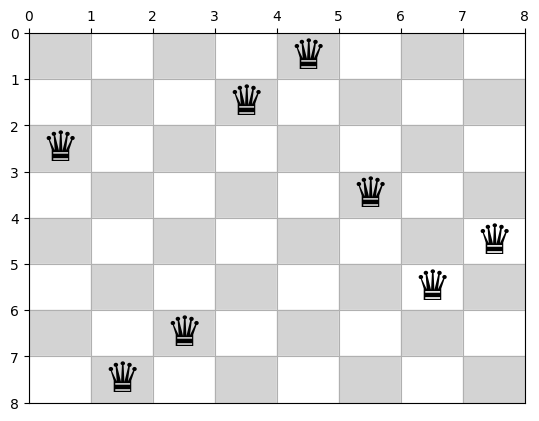

Melhor solução: [6, 4, 1, 4, 8, 5, 3, 7] com custo: 2


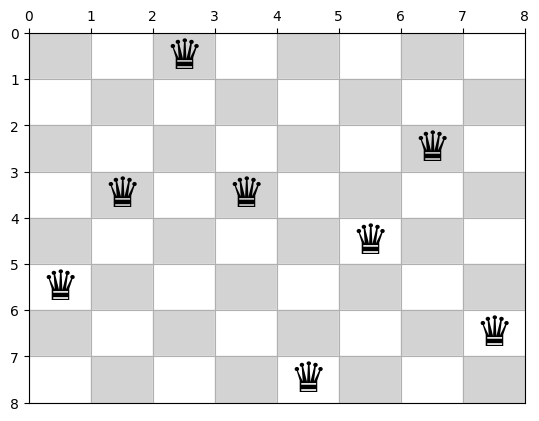

In [42]:
vetorInicial = solucao_aleatoria()

print("Tabuleiro recebido:", vetorInicial, "com custo:", conta_ataques(vetorInicial))
plota_tabuleiro(vetorInicial)

custo, vetor_melhor = hill_climbing_restart(vetorInicial)

print("Melhor solução:", vetor_melhor, "com custo:", custo)
plota_tabuleiro(vetor_melhor)